# Importing Libraries


In [62]:
# libraries
! pip install contractions
! pip install gensim
import contractions
import gensim
import os
import pandas as pd
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from collections import Counter
from wordcloud import WordCloud

# Loading Data


In [63]:
# loading data

data_directory = '/content/Data 2024'

# Converting data into Dataframe

article_names = []
article_contents = []

# Looping through all files in the directory
for file in os.listdir(data_directory):
    if file.endswith('.txt'):  # Ensure it's a .txt file
        file_path = os.path.join(data_directory, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        article_names.append(file)
        article_contents.append(content)


# Create a DataFrame
df = pd.DataFrame({
    'file_name': article_names,
    'content': article_contents})

# Exploratory Data Analysis(EDA)

In [64]:
# Basic overview of the dataset
print("df.info()\n")
df.info()
print("\ndf.head()\n")
print(df.head())

# Check for empty documents
df['content_length'] = df['content'].apply(lambda x: len(str(x)))
empty_docs = df[df['content_length'] == 0]
print(f"\nNumber of empty documents: {len(empty_docs)}")


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  277 non-null    object
 1   content    277 non-null    object
dtypes: object(2)
memory usage: 4.5+ KB

df.head()

         file_name                                            content
0   article 28.txt  Only some people benefitting from 'system', ot...
1  article 112.txt  Lok Sabha polls: SWOT analysis of parties in M...
2    article 7.txt  PM Modi's attack on Opposition in Lok Sabha in...
3  article 166.txt  India has an unbroken culture of democracy: PM...
4  article 149.txt  Lok Sabha polls: Will seek votes on basis of w...

Number of empty documents: 0


count     277.000000
mean      481.761733
std       228.407422
min       112.000000
25%       320.000000
50%       417.000000
75%       585.000000
max      1773.000000
Name: doc_length, dtype: float64


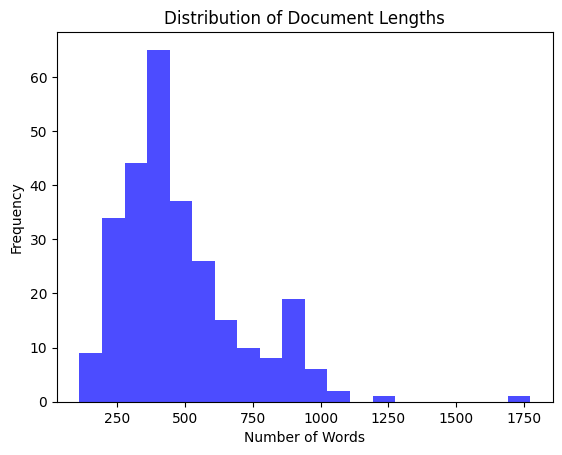

In [65]:
# Calculate document lengths in words
df['doc_length'] = df['content'].apply(lambda x: len(str(x).split()))

# Summary statistics
print(df['doc_length'].describe())

# Plot histogram of document lengths

plt.hist(df['doc_length'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Most common raw words: [('the', 9233), ('of', 3577), ('in', 3235), ('and', 3219), ('to', 3112), ('a', 2079), ('is', 1523), ('that', 1315), ('for', 1266), ('on', 1196), ('The', 911), ('has', 903), ('will', 874), ('Congress', 812), ('BJP', 751), ('he', 736), ('from', 722), ('as', 691), ('said', 670), ('with', 657)]


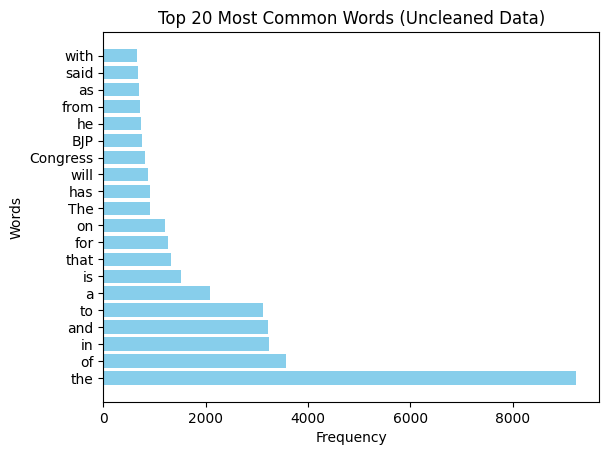

In [66]:
# Flatten all words in the corpus
all_words_raw = [word for doc in df['content'] for word in str(doc).split()]

# Count word frequencies
word_counts_raw = Counter(all_words_raw)
most_common_words_raw = word_counts_raw.most_common(20)
print("Most common raw words:", most_common_words_raw)

# Plot the most common words
words, counts = zip(*most_common_words_raw)
plt.barh(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words (Uncleaned Data)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


count    277.000000
mean      79.729242
std       39.682649
min       14.000000
25%       54.000000
50%       73.000000
75%       96.000000
max      214.000000
Name: special_char_count, dtype: float64


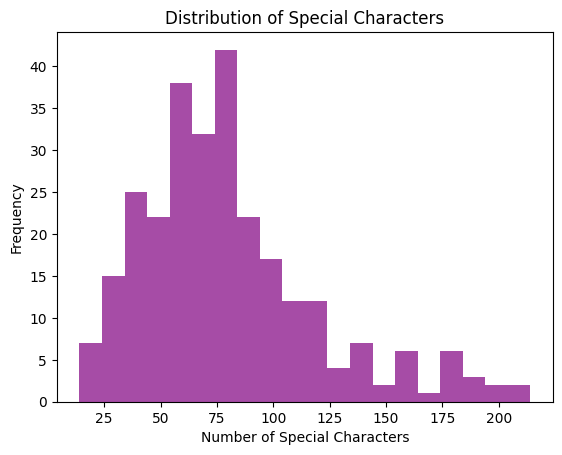

In [67]:
# Count special characters and punctuation in a document
def count_special_chars(text):
    return len(re.findall(r'[^\w\s]', str(text)))

df['special_char_count'] = df['content'].apply(count_special_chars)
print(df['special_char_count'].describe())

# Plot distribution of special characters
plt.hist(df['special_char_count'], bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Special Characters")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()


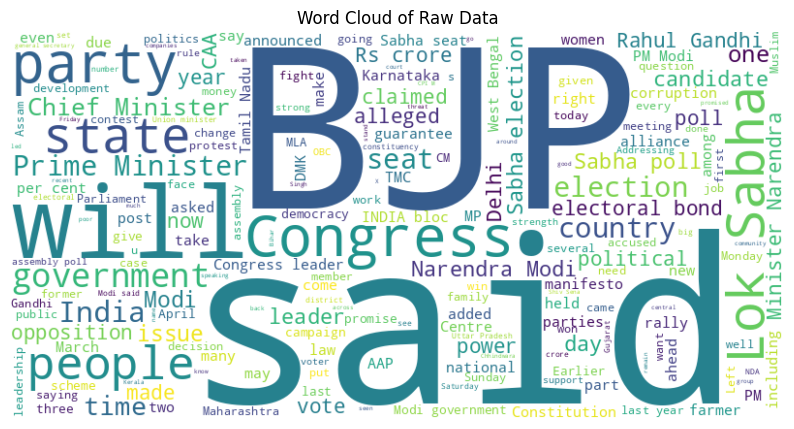

In [68]:
# Join all documents into one text
all_text_raw = ' '.join(str(doc) for doc in df['content'])

# Generate a word cloud
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(all_text_raw)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Raw Data")
plt.show()

In [69]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Count stopwords in the raw corpus
stopword_counts_raw = sum(word.lower() in stop_words for word in all_words_raw)
print(f"Number of stopwords in the dataset: {stopword_counts_raw}")


Number of stopwords in the dataset: 53242


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Cleaning Data


In [70]:
# cleaning data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
special_words = [ 'nath','modi', 'gandhi', 'rahul', 'nakul','kamal','yadav','kharge','kharge','kejriwal','said','arvind','kejriwals','mamata','banerjee']

def expand_contractions(text):
    return contractions.fix(text)

def remove_single_characters(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)

def preprocess_text(text):
    # Expand contractions
    text = expand_contractions(text)

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove single characters
    text = remove_single_characters(text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in special_words]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the content column
df['cleaned_content'] = df['content'].apply(preprocess_text)

print(df.head)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<bound method NDFrame.head of            file_name                                            content  \
0     article 28.txt  Only some people benefitting from 'system', ot...   
1    article 112.txt  Lok Sabha polls: SWOT analysis of parties in M...   
2      article 7.txt  PM Modi's attack on Opposition in Lok Sabha in...   
3    article 166.txt  India has an unbroken culture of democracy: PM...   
4    article 149.txt  Lok Sabha polls: Will seek votes on basis of w...   
..               ...                                                ...   
272   article 67.txt  Bansuri Swaraj hits back after AAP alleges BJP...   
273  article 275.txt  Modi govt was ' dragged into' providing free C...   
274  article 235.txt  BJP playing game of deceit and bargaining ahea...   
275   article 10.txt  Lok Sabha Elections: Asaduddin Owaisi-led AIMI...   
276  article 254.txt  Katchatheevu row: M K Stalin questions BJP's '...   

     content_length  doc_length  special_char_count  \
0             

Most common raw words: [('party', 1092), ('congress', 986), ('bjp', 952), ('minister', 714), ('election', 591), ('sabha', 572), ('government', 568), ('state', 567), ('lok', 535), ('leader', 507), ('india', 455), ('also', 445), ('people', 438), ('poll', 429), ('seat', 390), ('chief', 312), ('prime', 275), ('country', 272), ('year', 264), ('electoral', 258)]


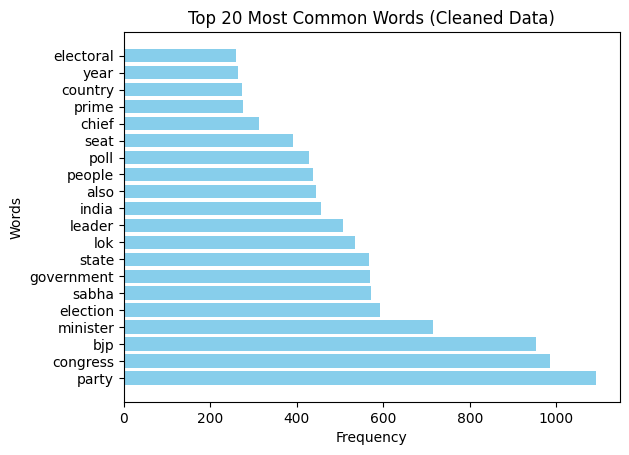

In [71]:
# Flatten all words in the corpus
all_words_raw = [word for doc in df['cleaned_content'] for word in str(doc).split()]

# Count word frequencies
word_counts_raw = Counter(all_words_raw)
most_common_words_raw = word_counts_raw.most_common(20)
print("Most common raw words:", most_common_words_raw)

# Plot the most common words
words, counts = zip(*most_common_words_raw)
plt.barh(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words (Cleaned Data)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

count    277.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: special_char_count, dtype: float64


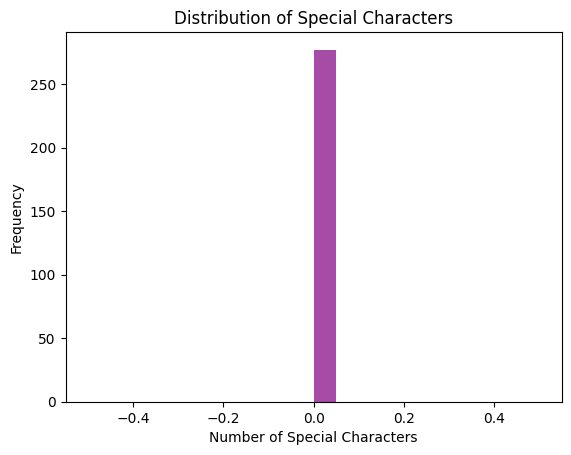

In [72]:
df['special_char_count'] = df['cleaned_content'].apply(count_special_chars)

print(df['special_char_count'].describe())

# Plot distribution of special characters
plt.hist(df['special_char_count'], bins=20, color='purple', alpha=0.7)
plt.title("Distribution of Special Characters")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()

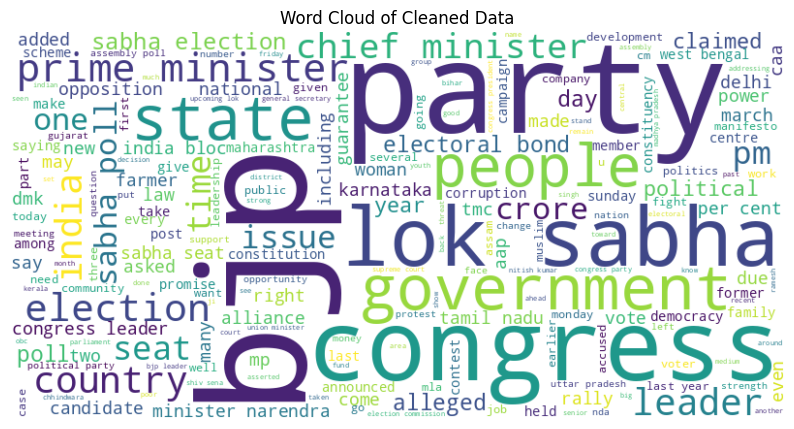

In [73]:
# Join all documents into one text
all_text_raw = ' '.join(str(doc) for doc in df['cleaned_content'])

# Generate a word cloud
wordcloud_raw = WordCloud(width=800, height=400, background_color='white').generate(all_text_raw)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Data")
plt.show()


# Prepairing Data


In [74]:
# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the cleaned content
dtm = vectorizer.fit_transform(df['cleaned_content'])

# Convert to a DataFrame (optional, for inspection)
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Inspect the matrix
print(dtm_df.head())


   aadhaar   aadmi     aam       aap  aapcongress      aaps  aasu   ab  \
0      0.0  0.0000  0.0000  0.000000          0.0  0.000000   0.0  0.0   
1      0.0  0.0000  0.0000  0.065117          0.0  0.000000   0.0  0.0   
2      0.0  0.0000  0.0000  0.000000          0.0  0.000000   0.0  0.0   
3      0.0  0.0000  0.0000  0.000000          0.0  0.000000   0.0  0.0   
4      0.0  0.1168  0.1168  0.149716          0.0  0.069232   0.0  0.0   

   abandoned  abdul  ...     young  younger  youngster  youth  ysrcp  yusuf  \
0        0.0    0.0  ...  0.000000      0.0        0.0    0.0    0.0    0.0   
1        0.0    0.0  ...  0.043121      0.0        0.0    0.0    0.0    0.0   
2        0.0    0.0  ...  0.000000      0.0        0.0    0.0    0.0    0.0   
3        0.0    0.0  ...  0.000000      0.0        0.0    0.0    0.0    0.0   
4        0.0    0.0  ...  0.000000      0.0        0.0    0.0    0.0    0.0   

   yuva  zero  zimik  zone  
0   0.0   0.0    0.0   0.0  
1   0.0   0.0    0.0  

# Non-Negative Matrix Factorization

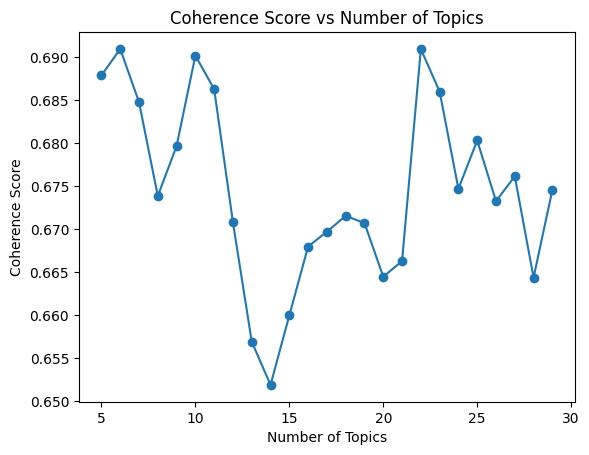

Number of Topics with highest coherence score: 6


In [75]:
def calculate_coherence_score(dtm, vectorizer, n_topics_range, texts):
    coherence_scores = []
    feature_names = vectorizer.get_feature_names_out()

    for n_topics in n_topics_range:
        # Fit NMF model
        nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=1000)
        W = nmf_model.fit_transform(dtm)
        H = nmf_model.components_

        # Get the top words for each topic
        topics = []
        for topic_idx, topic in enumerate(H):
            top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
            topics.append(top_words)

        # Create a gensim dictionary and corpus
        dictionary = Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]

        # Calculate coherence score
        coherence_model = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((n_topics, coherence_score))

    return coherence_scores

n_topics_range = range(5, 30)
texts = [doc.split() for doc in df['cleaned_content']]

# Calculate coherence scores
coherence_scores = calculate_coherence_score(dtm, vectorizer, n_topics_range, texts)

# Plot coherence scores
n_topics, scores = zip(*coherence_scores)
plt.plot(n_topics, scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

# Print the optimal number of topics
optimal_n_topics = n_topics[scores.index(max(scores))]
print(f"Number of Topics with highest coherence score: {optimal_n_topics}")


Number of Topics: 5
Reconstruction Error: 15.552563230066236
Number of Topics: 6
Reconstruction Error: 15.44734561023577
Number of Topics: 7
Reconstruction Error: 15.349240327152833
Number of Topics: 8
Reconstruction Error: 15.261650019269311
Number of Topics: 9
Reconstruction Error: 15.178035599296747
Number of Topics: 10
Reconstruction Error: 15.091006530927551
Number of Topics: 11
Reconstruction Error: 15.009668378413538
Number of Topics: 12
Reconstruction Error: 14.926738459923513
Number of Topics: 13
Reconstruction Error: 14.839573163158601
Number of Topics: 14
Reconstruction Error: 14.763087702163798
Number of Topics: 15
Reconstruction Error: 14.682873472564587


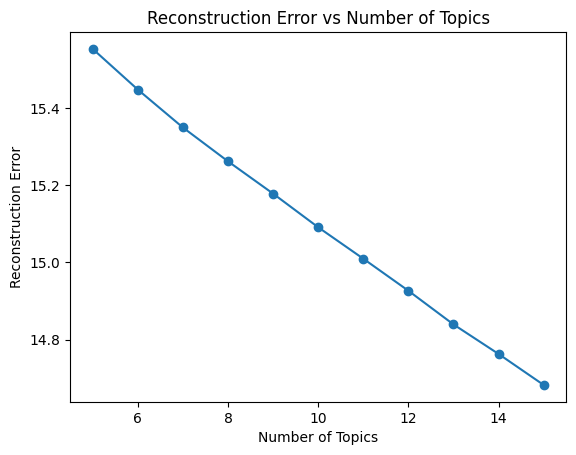

In [76]:
# Test NMF with different numbers of topics
errors = []
for n_topics in range(5, 16):
    nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=1000)
    W = nmf_model.fit_transform(dtm)
    H = nmf_model.components_
    errors.append(nmf_model.reconstruction_err_)
    print(f"Number of Topics: {n_topics}")
    print(f"Reconstruction Error: {nmf_model.reconstruction_err_}")

# Plot the reconstruction errors
plt.plot(range(5, 16), errors, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Topics')
plt.show()


In [77]:
# Set number of topics
n_topics = 10

# Apply NMF
nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=500)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_         # Topic-term matrix

# Get the top terms for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic #1:
congress karnataka seat bjp party chhindwara sabha candidate mp lok
Topic #2:
bond electoral crore donor donation company court profit donated sbi
Topic #3:
caa citizenship bengal matua rule amendment bangladesh tmc act law
Topic #4:
constitution rally democracy minister india country opposition prime people leader
Topic #5:
dmk tamil nadu katchatheevu lanka aiadmk sri stalin island minister
Topic #6:
delhi aap punjab candidate swaraj lok sabha mann seat aam
Topic #7:
manifesto nyay congress guarantee yatra caste party promise census promised
Topic #8:
paper upa white sitharaman government economy economic crisis finance budget
Topic #9:
party bjp state strength poll weakness seat opportunity threat assembly
Topic #10:
farmer government msp price post support border youth life bharat
